<a href="https://colab.research.google.com/github/astrohayley/favorite-notebooks/blob/main/Galaxy_Zoo_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy Zoo Deep Convolutional Generative Adversarial Network

Can we create "simulated" galaxy images with a DCGAN from fastai?

This is just a bunch of fun, with lots of help from the DCGAN [tutorial here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

## Data and Setup
Bring in imports, downloaded data we need

In [7]:
from fastai.basics import *
from fastai.vision.all import *

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plot = lambda: sns.set(context='paper', font_scale=1.2, style='ticks', palette = 'Dark2', 
        rc={'figure.figsize':(5,3), 'xtick.bottom': True, 'ytick.left':True, 
        'figure.dpi':150, 'figure.facecolor':'w', 'errorbar.capsize': 2, 
        'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': 'monospace'})

plot()

%matplotlib inline

rng = np.random.RandomState(123)
torch.manual_seed(123)

SDSS color images I have downloaded come from the Galaxy Zoo 2 catalog, found [here](https://data.galaxyzoo.org/).  

In [2]:
!wget -q -nc -O sdss_images.tar.gz https://www.dropbox.com/s/bvpp3okp2ypjzpg/sdss_images.tar.gz?dl=0
!tar xzf sdss_images.tar.gz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.trash.put-back.path#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.trash.put-back.icloud-parent-id#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:_kMDItemUserTags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:_kMDItemUserTags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:_kMDItemUserTags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:_kMDItemUserTags'


In [3]:
!wget -O gz2_hart16_morphology.fits https://www.dropbox.com/s/e47naz3u1bcuakm/gz2_hart16_morphology.fits?dl=0

--2023-02-03 08:19:08--  https://www.dropbox.com/s/e47naz3u1bcuakm/gz2_hart16_morphology.fits?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/e47naz3u1bcuakm/gz2_hart16_morphology.fits [following]
--2023-02-03 08:19:09--  https://www.dropbox.com/s/raw/e47naz3u1bcuakm/gz2_hart16_morphology.fits
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4f9df99d0e5f4442bd14a7b548.dl.dropboxusercontent.com/cd/0/inline/B1yfj5qZGWsunVOfheMWiRvAbxZ8tib4jcMEqI_etrr2DxVNJtB8djQwHACa5FrQ4z1Jr3ZUKomFfF82DJHiOGlHPRiGfbf_6pW0F-6R52r59hYaNPIzihWesUO_ZAGJ-Ue0kgwjGWQZrO0JIVE2l7y72l4JIklny-kr2tSOO87D0w/file# [following]
--2023-02-03 08:19:09--  https://uc4f9df99d0e5f4442bd14a7b548.dl.dropboxusercontent.com/cd/0/inline/B1yfj5qZGWsunVOfheMWiRvAbxZ8tib

Load in images using the `dataloader` from fastai and show some example images

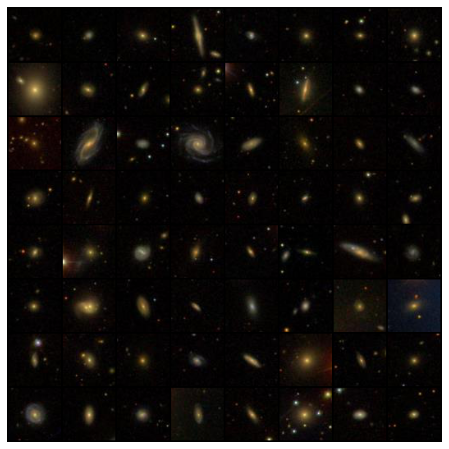

In [10]:
rootfolder = "sdss_images"
batch_size = 256
image_size = 64

lr = 1e-3
beta1 = 0.5
ngpu = 1 # use 0 for cpu

nc = 3 # number of channels
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator

dataset = dset.ImageFolder(root=rootfolder,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=2)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Building the DCGAN

Start with weights from a random distribution and stdev=0.02

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Setting up the generator for the DCGAN

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Initialize generator and print the structure of the code

In [13]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Construct the discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Initialize the loss function

In [16]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Train the DCGAN

In [17]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs=10


for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/10][0/196]	Loss_D: 2.2136	Loss_G: 5.8544	D(x): 0.2300	D(G(z)): 0.4096 / 0.0054
[0/10][50/196]	Loss_D: 27.2145	Loss_G: 9.7429	D(x): 1.0000	D(G(z)): 1.0000 / 0.0746
[0/10][100/196]	Loss_D: 0.4339	Loss_G: 2.1886	D(x): 0.9023	D(G(z)): 0.2757 / 0.1235
[0/10][150/196]	Loss_D: 1.1019	Loss_G: 3.4249	D(x): 0.9308	D(G(z)): 0.6155 / 0.0486
[1/10][0/196]	Loss_D: 1.9742	Loss_G: 0.8969	D(x): 0.1849	D(G(z)): 0.1034 / 0.4126
[1/10][50/196]	Loss_D: 1.5740	Loss_G: 0.4761	D(x): 0.2811	D(G(z)): 0.1804 / 0.6277
[1/10][100/196]	Loss_D: 1.7550	Loss_G: 1.7362	D(x): 0.7391	D(G(z)): 0.7462 / 0.1904
[1/10][150/196]	Loss_D: 1.5461	Loss_G: 0.9702	D(x): 0.4969	D(G(z)): 0.5460 / 0.4014
[2/10][0/196]	Loss_D: 1.4076	Loss_G: 0.7902	D(x): 0.4269	D(G(z)): 0.3442 / 0.4763
[2/10][50/196]	Loss_D: 1.4428	Loss_G: 0.6698	D(x): 0.3519	D(G(z)): 0.2646 / 0.5253
[2/10][100/196]	Loss_D: 1.1347	Loss_G: 0.9367	D(x): 0.6710	D(G(z)): 0.4592 / 0.4275
[2/10][150/196]	Loss_D: 1.3432	Loss_G: 1.7823	D(x): 0.6742	D(G(z)): 0.5327 / 0.1813


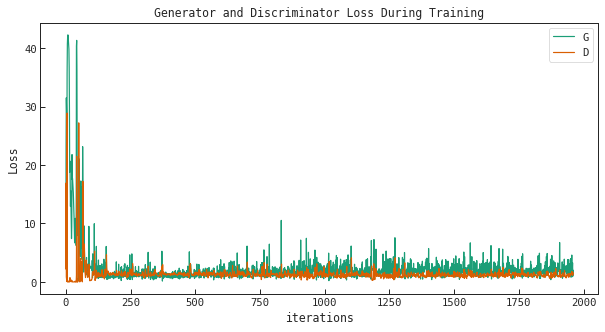

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Real vs. Fake Images

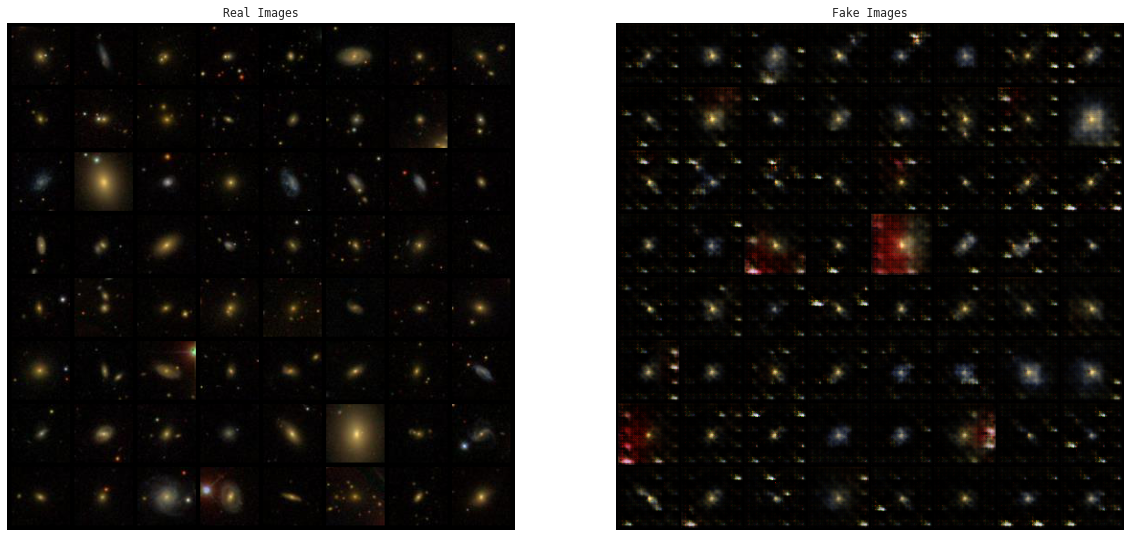

In [21]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

(-0.5, 529.5, 529.5, -0.5)

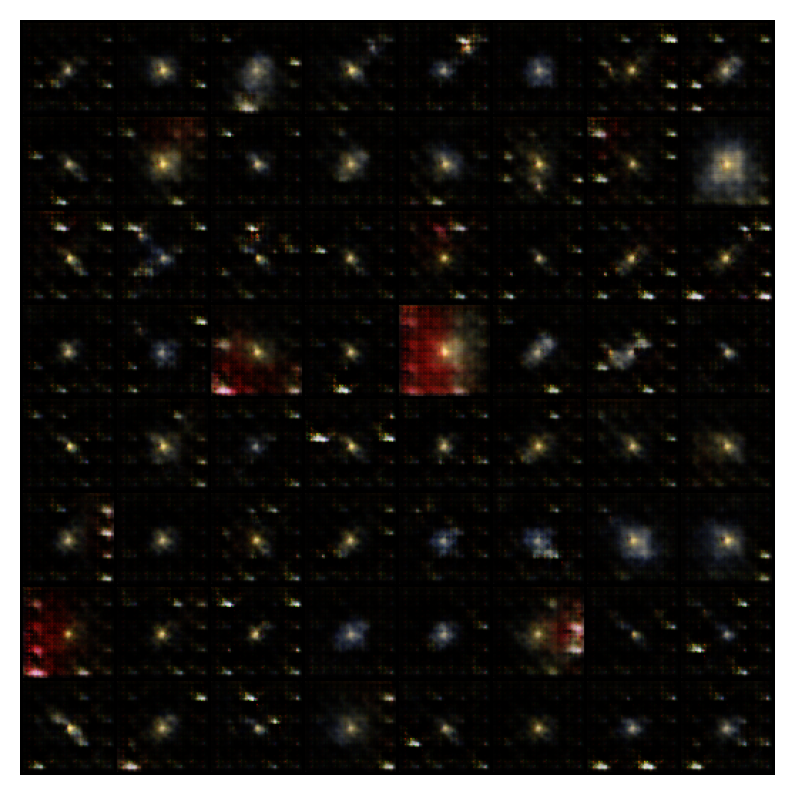

In [33]:
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.axis('off')

Not bad for ~10m on Colab and with only 50,000 images. Maybe worth trying with a larger sample?